In [50]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
import pickle

with open("/data/pv-labels.pkl", "rb") as f:
    raw = pickle.load(f)




In [51]:
import numpy as np

def wr_up(bars):
    shadow = bars["high"] - bars["close"]
    return shadow/(bars["high"] - bars["low"]+1e-7)

def wr_down(bars):
    shadow = bars["close"] - bars["low"]
    return shadow/(bars["high"] - bars["low"]+1e-7)

def upper_shadow(bars):
    shadow = bars["high"] - np.maximum(bars["open"], bars["close"])
    
    # 正则化
    return shadow/(bars["high"] - bars["low"]+1e-7)

def lower_shadow(bars):
    shadow = np.minimum(bars["open"], bars["close"]) - bars["low"]
    
    # 正则化
    return shadow/(bars["high"] - bars["low"]+1e-7)

bars = raw[["open", "high", "low", "close"]].to_records(index=False)
data = {
    "label": raw["flag"].values,
    "data": np.vstack(
        (wr_up(bars), 
         wr_down(bars), 
         upper_shadow(bars), 
         lower_shadow(bars)
        )
        ).T
}

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['label'] + 1, test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=3, max_depth=2, learning_rate=0.5)
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)


In [53]:
from sklearn.metrics import *

# https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary
acc = accuracy_score(y_test,preds)
print(f"ACC: {acc:.3f}")

recall = recall_score(y_test,preds, average='weighted')
print(f"Recall:{recall:.1%}")

f1 = f1_score(y_test,preds, average='weighted')
print(f"F1-score: {f1:.1%}")

precision = precision_score(y_test,preds, average='weighted')
print(f"Precesion:{precision:.1%}")
mx = confusion_matrix(y_test,preds)


ACC: 0.922
Recall:92.2%
F1-score: 88.4%
Precesion:84.9%


/home/aaron/miniconda3/envs/pluto/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

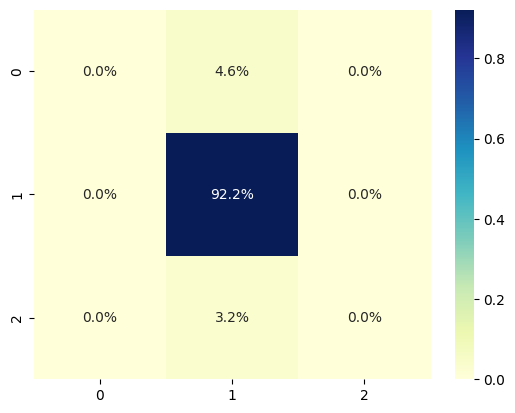

In [54]:
import seaborn as sns

sns.heatmap(mx/np.sum(mx), cmap="YlGnBu", annot=True, fmt=".1%")